In [1]:
import h5py
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import netCDF4 as nc
import os

In [ ]:
############### NO2 trend
# vmin=1.9751113e+15, vmax=1.0216632e+16
def new_plot(data, lat, lon):

    mean = np.mean(data)
    max_val = np.nanmax(data)
    min_val = np.nanmin(data)

    # Define levels and colormap
    levels = np.linspace(0, 1, 21)
    cmap = plt.get_cmap('bwr', len(levels) - 1)

    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    img = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap, shading='auto',
        vmin=-1, vmax=1 
             
    )

    plt.colorbar(img, ax=ax, orientation='vertical', label='NO₂ (molec/cm²)')

    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linewidth=0.5)  # <-- add state borders
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([-83.125, -70.0, 36.125, 43.125], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # Annotate mean, min, max
    plt.text(0.99, 0.04, f'Mean: {mean:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.12, f'Min: {min_val:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.20, f'Max: {max_val:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # --- Major cities (lat, lon, name) ---
    cities = [
        (40.7128, -74.0060, "New York"),
        (39.9526, -75.1652, "Philadelphia"),
        (38.9072, -77.0369, "Washington, D.C."),
        (41.4993, -81.6944, "Cleveland"),
        (42.3601, -71.0589, "Boston"),
        (39.2904, -76.6122, "Baltimore"),
        (40.4406, -79.9959, "Pittsburgh")
    ]
    for lat_c, lon_c, name in cities:
        ax.plot(lon_c, lat_c, 'ro', markersize=4, transform=ccrs.PlateCarree())
        ax.text(lon_c + 0.2, lat_c + 0.2, name, fontsize=9,
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.title(f'NO₂ (cloud-screened tropospheric column) trend: 2005-2024')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()



def fill_neg(dataset, var):   # create a new ds that only takes values >= 0-- values below 0 will be made into NaN
  filled_no2 = dataset[var].where(dataset[var] >= 0, other=np.nan)
  return filled_no2


def gridded_avg(data_list):
  combined_dataset = xr.concat(data_list, dim='time') # dataset of all 365 days' data in the year
  # Calculate the average along the time dimension
  average_data = combined_dataset.mean(dim='time')
  return average_data


def create_avg_ds(main_dir,variable):
  year_ds = [] # list of datasets from 1 year
  avg_datasets = [] # list of all years' avg datasets--- this is your result that you want to use!

  #main_dir = "/content/drive/MyDrive/Air_pollution_2025/cleaned_data/clean_no2/"
  sorted_main = os.listdir(main_dir)
  sorted_main.sort() # sort so that the years are in ascending order
  file_list = []
  for x in range(20):
    new_file = os.path.join(main_dir, sorted_main[x])
    file_list.append(new_file)

  # Get a list of all files in the folder
  for year_folder in file_list: # loop through year folders of main directory of no2
    print(year_folder)
    for filename in os.listdir(year_folder): # loop through files within the year folder
        if filename.endswith('.nc'): # Process only NetCDF files
            file_path = os.path.join(year_folder, filename)
            ds = xr.open_dataset(file_path)
            filled_data = fill_neg(ds, variable) # fill negative values with NaN
            year_ds.append(filled_data)
            #ds.close()
    #combine data here
    avg_datasets.append(gridded_avg(year_ds)) # calculate the gridded average + add to the list
    year_ds = [] # empty year_ds for the next year

  return avg_datasets




In [6]:
# vmin=1.9751113e+15, vmax=1.0216632e+16
def plot_no2(data_array, date):

    mean = np.mean(data_array)
    max = np.nanmax(data_array)
    min = np.nanmin(data_array)

    lat = data_array.lat.values
    lon = data_array.lon.values
    data = data_array.values

    # Define levels and colormap
    levels = np.linspace(0, 1, 21)
    cmap = plt.get_cmap('viridis', len(levels) - 1)

    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    img = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                        cmap=cmap, shading='auto',
                        vmin=1.5e+15, vmax=1.00001+16)

    plt.colorbar(img, ax=ax, orientation='vertical', label='NO₂ (molec/cm²)')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([-81, -73, 38, 41], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # Add mean, min, and max annotations
    plt.text(0.99, 0.04, f'Mean: {mean:.2e}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.12, f'Min: {min:.2e}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.20, f'Max: {max:.2e}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


    plt.title(f'NO₂ (cloud-screened tropospheric column): {date}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Ensure 'outputs' folder exists
    output_dir = "outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"no2_{date}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')


In [12]:
# vmin=1.9751113e+15, vmax=1.0216632e+16
def new_plot(data, lat, lon, date):

    mean = np.mean(data)
    max_val = np.nanmax(data)
    min_val = np.nanmin(data)

    # Define levels and colormap
    levels = np.linspace(0, 1, 21)
    cmap = plt.get_cmap('viridis', len(levels) - 1)

    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    img = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap, shading='auto',
        # vmin=1.5e+15, vmax=1.00001e+16   # for NO2
        vmin=272, vmax=285                 # for O3
    )

    plt.colorbar(img, ax=ax, orientation='vertical', label='NO₂ (molec/cm²)')

    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linewidth=0.5)  # <-- add state borders
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([-83.125, -70.0, 36.125, 43.125], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # Annotate mean, min, max
    plt.text(0.99, 0.04, f'Mean: {mean:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.12, f'Min: {min_val:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.99, 0.20, f'Max: {max_val:.2e}', ha='right', va='bottom',
             transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # --- Major cities (lat, lon, name) ---
    cities = [
        (40.7128, -74.0060, "New York"),
        (39.9526, -75.1652, "Philadelphia"),
        (38.9072, -77.0369, "Washington, D.C."),
        (41.4993, -81.6944, "Cleveland"),
        (42.3601, -71.0589, "Boston"),
        (39.2904, -76.6122, "Baltimore"),
        (40.4406, -79.9959, "Pittsburgh")
    ]
    for lat_c, lon_c, name in cities:
        ax.plot(lon_c, lat_c, 'ro', markersize=4, transform=ccrs.PlateCarree())
        ax.text(lon_c + 0.2, lat_c + 0.2, name, fontsize=9,
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.title(f'NO₂ (cloud-screened tropospheric column): {date}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


In [3]:
file_path = '/home/ellab/air_pollution/src/data/clean_no2/2011/omi_no2_20110114_clean.nc'
data = xr.open_dataset(file_path)
no2_data = data['NO2']

latitude = data['lat']
longitude = data['lon']


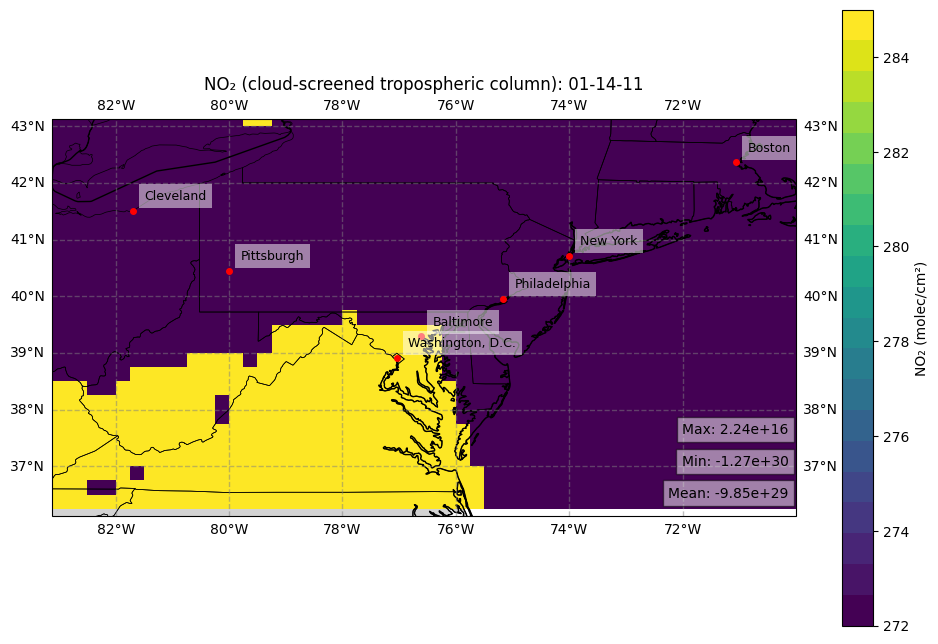

In [13]:
new_plot(no2_data, latitude, longitude, '01-14-11')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def plot_day(index):
    # Get date from index
    date = str(data_2005.time[index].values)[:10]

    # Extract 2D slice
    da = data_2005['NO2TropCloudScreened'].isel(time=index)

    # Prepare data
    lat = da.lat.values
    lon = da.lon.values
    data = da.values

    # Plot setup
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    img = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                        cmap='viridis', shading='auto',
                        vmin=1.5e+15, vmax=1.00001+16)

    plt.colorbar(img, ax=ax, label="NO₂ (molec/cm²)")
    ax.set_extent([-81, -73, 38, 41], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_title(f"Cloud-screened Tropospheric NO₂: {date}")
    plt.show()

# Slider for day index
slider = widgets.IntSlider(value=0, min=0, max=364, step=1, description='Day')

# Connect slider to plot
widgets.interact(plot_day, index=slider)
